## Logistic Regression
### Logistic regression is commonly used for binary classification, i.e. classifying data into 2 separate groups (true or false, pass or fail, 0 or 1 etc.) Bear in mind that this results in discrete outcome, which is in contrast with other methods that predicts continuous results like linear regression.

### How does it work?
* Similar to linear regression, it measures the relationship between one or more independent features and the dependent feature, aka the label. This is done using its underlying logistic function. The sigmoid function is as follow:

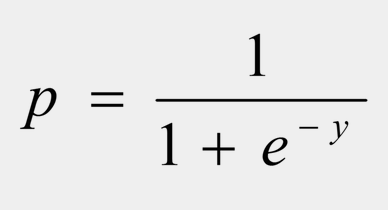

* And the logistic regression formula can be denoted as follow:
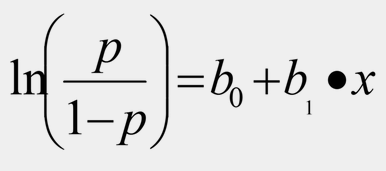

* Let us try using logistic regression on a sample dataset. The data that will be used can be found from: https://www.kaggle.com/rikdifos/credit-card-approval-prediction/code Note that, this is just a demonstration of how logistic regression would work so it may not be fully comprehensive

In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

In [2]:
import os
for dirname, _, filenames in os.walk('./log_reg_data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./log_reg_data/application_record.csv
./log_reg_data/credit_record.csv


In [4]:
df1 = pd.read_csv("./log_reg_data/application_record.csv")
df2 = pd.read_csv("./log_reg_data/credit_record.csv")

In [5]:
df1.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [6]:
df2.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [11]:
# Replace C and X with 0, expanding the 0 group to 0-29 days past due, so that we have all numeric categories for delinquency status.
df2['STATUS'] = df2['STATUS'].replace(['X'],0)
df2['STATUS'] = df2['STATUS'].replace(['C'],0)

# Convert status to numeric and group-max by status for each unique id.  
df2['STATUS'] = df2['STATUS'].apply(pd.to_numeric) 
# Select highest status, i.e. the highest level of delinquency for each customer id
df2 = df2.groupby('ID')['STATUS'].max().reset_index()
# export data to csv file
df2.to_csv('df_credit.csv',index=False)

df2.groupby('ID')['STATUS'].count().reset_index()

,ID,STATUS
0,5001711,1
1,5001712,1
2,5001713,1
3,5001714,1
4,5001715,1
...,...,...
45980,5150482,1
45981,5150483,1
45982,5150484,1
45983,5150485,1


In [12]:
#  Join grouped status table to df_app by ID 
df_consol = pd.merge(df1, df2, left_on='ID', right_on='ID')
df_consol.shape

(36457, 19)

In [13]:
# convert status to binary.  If < 1, then 
df_consol['high_risk'] = np.where(df_consol['STATUS']<1, 0, 1)

# convert days old to years
df_consol['age_years'] = round(df_consol['DAYS_BIRTH']/-365,0).astype(int)
df_consol['years_employed'] = round(df_consol['DAYS_EMPLOYED']/-365,0).astype(int)

df_consol.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS,high_risk,age_years,years_employed
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,1,1,33,12
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,1,1,33,12
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,0,0,59,3
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,0,0,52,8
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,0,0,52,8


In [14]:
#  Encode categorical columns
df_formatted = pd.get_dummies(df_consol, columns=['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                                   'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'],               
               prefix=["gender", "own_car", 'own_property', 'income_type', 'education', 'family_status', 'housing_type',
                      'occupation_type'])

# check length-rows and width-columns of data
df_formatted.shape

(36457, 59)

In [15]:
df_formatted.head(5)

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,...,occupation_type_Laborers,occupation_type_Low-skill Laborers,occupation_type_Managers,occupation_type_Medicine staff,occupation_type_Private service staff,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Waiters/barmen staff
0,5008804,0,427500.0,-12005,-4542,1,1,0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,5008805,0,427500.0,-12005,-4542,1,1,0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,5008806,0,112500.0,-21474,-1134,1,0,0,0,2.0,...,0,0,0,0,0,0,0,0,1,0
3,5008808,0,270000.0,-19110,-3051,1,0,1,1,1.0,...,0,0,0,0,0,0,1,0,0,0
4,5008809,0,270000.0,-19110,-3051,1,0,1,1,1.0,...,0,0,0,0,0,0,1,0,0,0


In [16]:
# drop columns not needed
df_formatted.drop(['ID'], axis=1, inplace=True)
df_formatted.drop(['STATUS'], axis=1, inplace=True)
df_formatted.drop(['DAYS_BIRTH'], axis=1, inplace=True)
df_formatted.drop(['DAYS_EMPLOYED'], axis=1, inplace=True)
df_formatted.drop(['own_car_N'], axis=1, inplace=True)
df_formatted.drop(['own_property_N'], axis=1, inplace=True)

df_formatted.to_csv('df_formatted.csv',index=False)

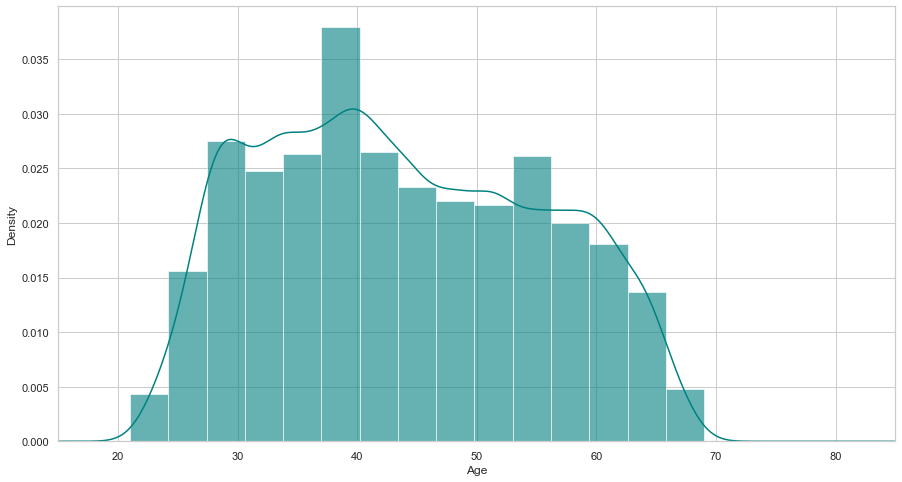

In [25]:
plt.figure(figsize=(15,8))

ax = df_formatted["age_years"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
df_formatted["age_years"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(15,85)
plt.show()

In [ ]:
# Assign target variable to separate array
target = np.array(df_formatted['high_risk'])

# Remove target column from features
features = df_formatted.drop('high_risk', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)
features.head(5)

In [41]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets.  test_size is n% of the rows. The other % will train the model.
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size = 0.25, random_state = 42)

# Check to see that training features and labels have the same rows, and testing features and labels have the same rows
print('Training Features Shape:', train_features.shape)
print('Training target Shape:', train_target.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing target Shape:', test_target.shape)

Training Features Shape: (27342, 52)
Training target Shape: (27342,)
Testing Features Shape: (9115, 52)
Testing target Shape: (9115,)


### Feature Selection
4.1.1. Recursive feature elimination

Given an external estimator that assigns weights to features, recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_, attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = features

# Build a logreg and compute the feature importances
model = LogisticRegression(solver='liblinear')

# create the RFE model and select 10 attributes
rfe = RFE(model, 10)
rfe = rfe.fit(train_features, train_target)

# summarize the selection of the attributes
print('Selected features: %s' % list(train_features.columns[rfe.support_]))

Selected features: ['FLAG_MOBIL', 'gender_F', 'gender_M', 'income_type_Student', 'education_Academic degree', 'occupation_type_IT staff', 'occupation_type_Low-skill Laborers', 'occupation_type_Private service staff', 'occupation_type_Realty agents', 'occupation_type_Waiters/barmen staff']


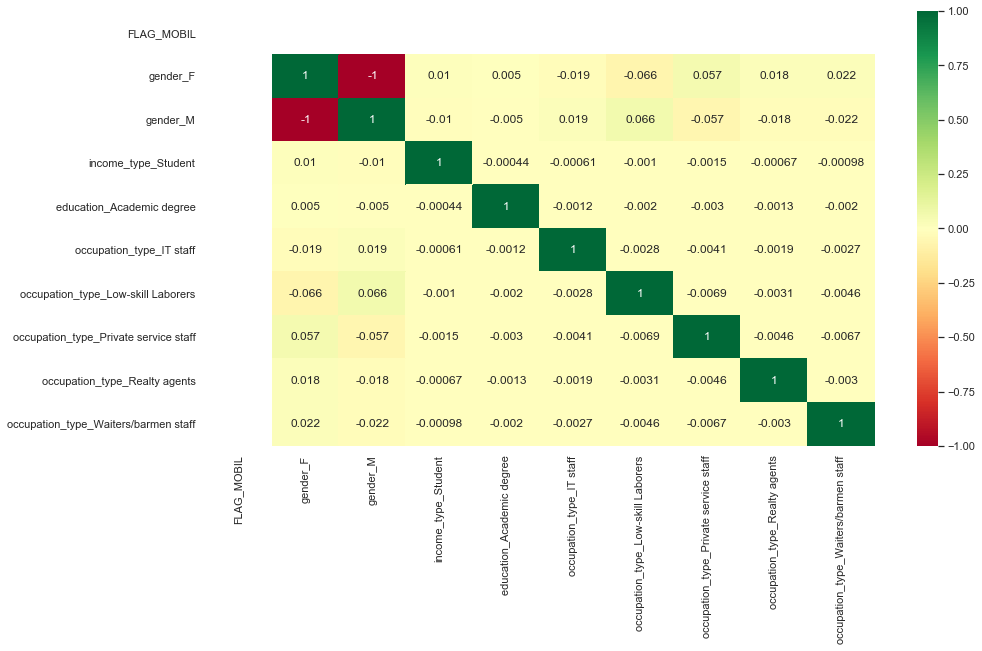

In [51]:
Selected_features = ['FLAG_MOBIL', 'gender_F', 'gender_M', 'income_type_Student', 'education_Academic degree', 'occupation_type_IT staff', 'occupation_type_Low-skill Laborers', 'occupation_type_Private service staff', 'occupation_type_Realty agents', 'occupation_type_Waiters/barmen staff']

X = train_features[Selected_features]
plt.figure(figsize=(15,8))
# plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

Train/Test split results:
LogisticRegression accuracy is 0.877
LogisticRegression log_loss is 0.372
LogisticRegression auc is 0.533


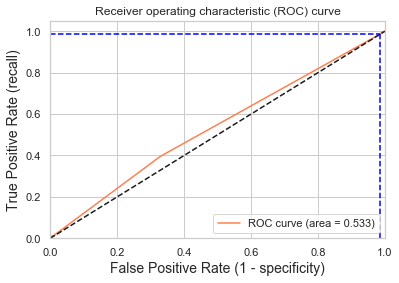

Using a threshold of 0.114 guarantees a sensitivity of 0.987 and a specificity of 0.014, i.e. a false positive rate of 98.57%.


In [56]:
# check classification scores of logistic regression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

train_features = train_features[Selected_features]
test_features = test_features[Selected_features]

logreg = LogisticRegression(solver='liblinear')
logreg.fit(train_features, train_target)
y_pred = logreg.predict(test_features)
y_pred_proba = logreg.predict_proba(test_features)[:, 1]
[fpr, tpr, thr] = roc_curve(test_target, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(test_target, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(test_target, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

The AUC is relatively poor as its barely pass 0.50. There is definitely room for improvement to improve the accuracy and different methods can be tried out, for eg. grid search for solver, using different set of features, etc. But this is the overview of how we can use logistic regression to perform binary classification